In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
# from NaiveForecast import NaiveForecast

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data Preprocessing

In [2]:
# top 7 MarketCap in S&P500(^GSPC)
tickers = ['^GSPC', 'AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'TSLA', 'META']

df_close = pd.DataFrame()

for ticker in tickers:
    data = pd.read_csv(f'data/{ticker}.csv', index_col="Date", parse_dates=True)
    
    close_prices = data['Close'].rename(ticker + "_close")
    
    df_close = pd.concat([df_close, close_prices], axis=1)

df_close.dropna(inplace=True)

In [3]:
df_log_return = pd.DataFrame()

for name in df_close.columns:
  col_name = name[:-6] + "_log_return"
  df_log_return[col_name] = np.log(df_close[name]).diff()
  
df_log_return['^GSPC_log_return'] = df_log_return['^GSPC_log_return'].shift(-1)
df_log_return['^GSPC_log_return'].tail()

2024-04-08 00:00:00    0.001444
2024-04-09 00:00:00   -0.009502
2024-04-10 00:00:00    0.007417
2024-04-11 00:00:00   -0.014658
2024-04-12 00:00:00         NaN
Name: ^GSPC_log_return, dtype: float64

# Model

In [4]:
df_to_model = df_log_return

In [5]:
Ntest = 1000
df_train = df_to_model.iloc[1:-Ntest]
df_test = df_to_model.iloc[-Ntest:-1]

X_train = df_train.drop(columns=['^GSPC_log_return'])
X_test = df_test.drop(columns=['^GSPC_log_return'])

y_train = df_train['^GSPC_log_return']
y_test = df_test['^GSPC_log_return']

## Train Model

In [6]:
naive_model = None
linear_model = LinearRegression()
# logistic_model = LogisticRegression()
svr_model = SVR()
rfr_model = RandomForestRegressor()
# lstm_model = LSTM()

models = {
    'NaiveForecast': naive_model,
    'LinearRegression': linear_model,
    # 'LogisticRegression': logistic_model,
    'SVR': svr_model,
    'RFR': rfr_model,
    # 'LSTM': lstm_model
}

In [7]:
results = {}

for name, model in models.items():
    if name == 'NaiveForecast':
        y_pred_test = y_test.shift(1).fillna(y_test.iloc[0]) # Backward Filling
        y_pred_train = y_train.shift(1).fillna(y_train.iloc[0])
    else:
        if name == 'LogisticRegression':
            y_train_bool = (y_train > 0) # Continuos -> Discrete(bool)
            model.fit(X_train, y_train_bool)
        else:
            model.fit(X_train, y_train)
        
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
    
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred_test)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred_test)
    rmse = np.sqrt(mse)
    
    results[name] = {
        'model': model,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'mae': mae,
        'mse': mse,
        'rmse': rmse
    }

Model: NaiveForecast
MAE: 0.0118
MSE: 0.0003
RMSE: 0.0159



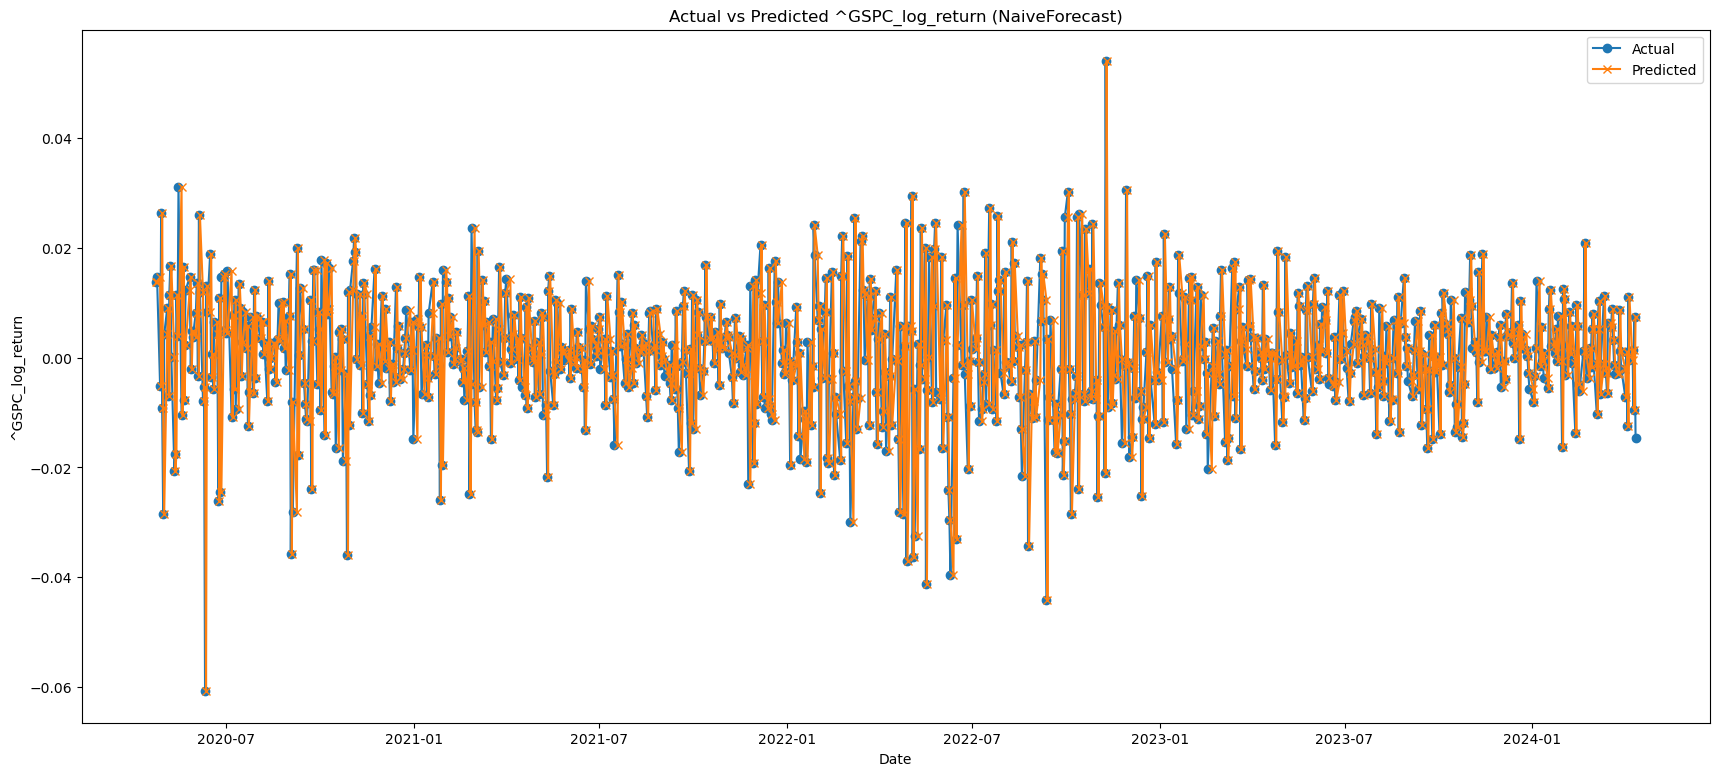

Model: LinearRegression
MAE: 0.0084
MSE: 0.0001
RMSE: 0.0112



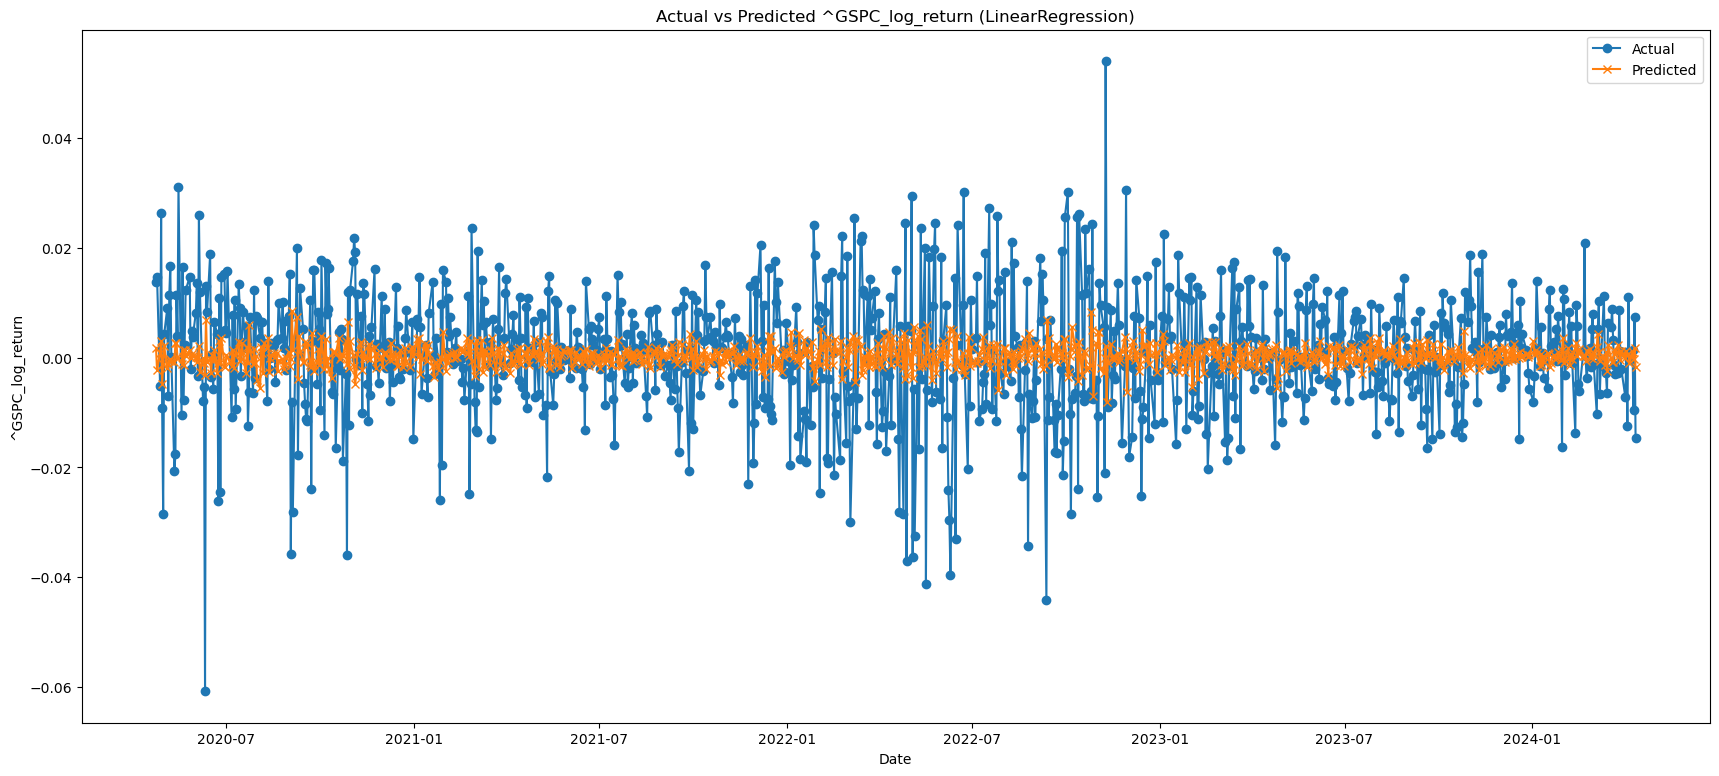

Model: SVR
MAE: 0.0169
MSE: 0.0004
RMSE: 0.0192



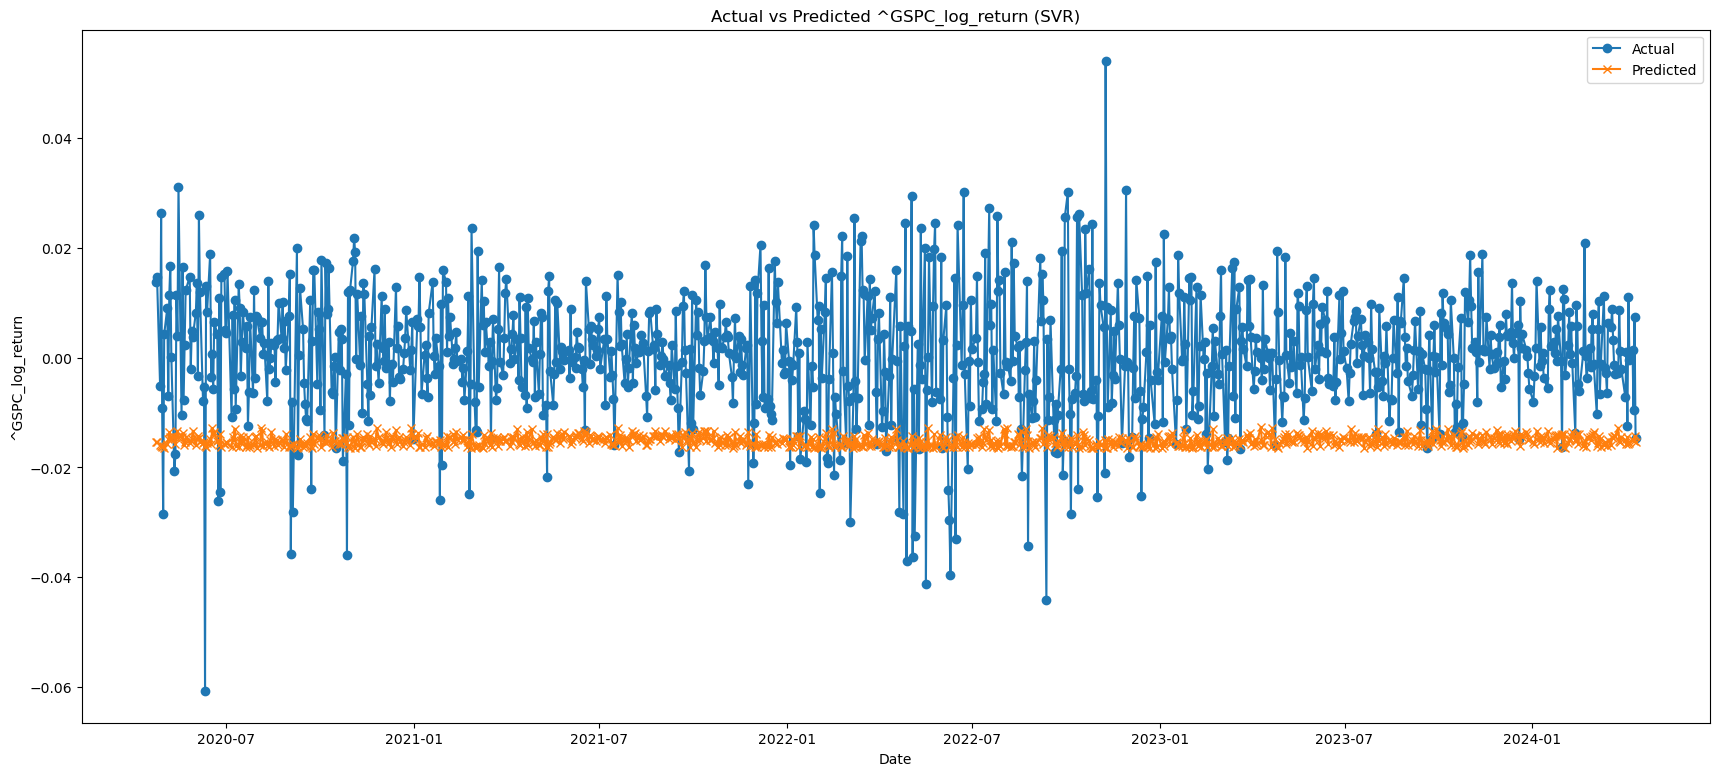

Model: RFR
MAE: 0.0088
MSE: 0.0001
RMSE: 0.0118



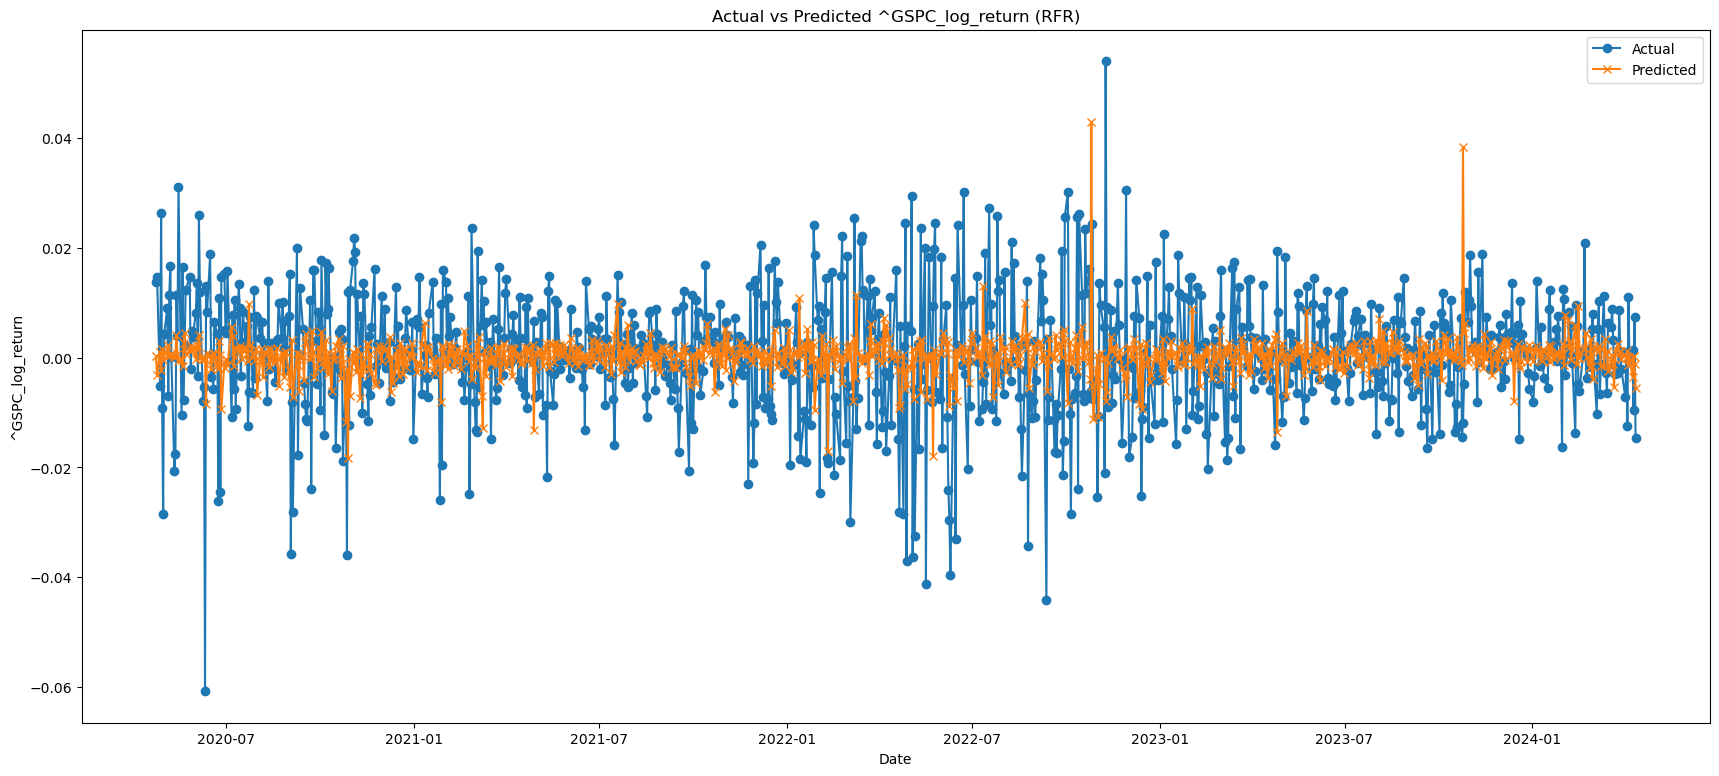

In [8]:
for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"MSE: {metrics['mse']:.4f}")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print()
    
    plt.figure(figsize=(21, 9))
    plt.plot(y_test.index, y_test, label='Actual', marker='o')
    plt.plot(y_test.index, metrics['y_pred_test'], label='Predicted', marker='x')
    plt.xlabel('Date')
    plt.ylabel('^GSPC_log_return')
    plt.title(f'Actual vs Predicted ^GSPC_log_return ({name})')
    plt.legend()
    plt.show()